In [6]:
from pathlib import Path
import Bio
from Bio.PDB import PDBList
import os
import shutil
from Bio.PDB import PDBParser
import mdtraj
from Bio.Align.Applications import ClustalOmegaCommandline
import subprocess
import biotite.sequence as seq
import biotite.sequence.graphics as graphics
from Bio import SeqIO

# List of PDB files/ids - as input to the workflow

In [4]:
# Get the PDB ID-s of your files

# Our example:
# PI3K pdb IDs - from the paper: https://doi.org/10.1016/j.jmb.2020.09.002 
# Supplementary material table S2.

pdbIds =  "2rd0 3hhm 3hiz 4jps 4l1b 4l23 4l2y 4ovu 4ovv 4waf 4ykn 4zop 5dxh 5fi4 5itd 5sw8 5swg 5swo 5swp 5swr 5swt 5sx8 5sx9 5sxa 5sxb 5sxc 5sxd 5sxe 5sxf 5sxi 5sxj 5sxk 5uk8 5ukj 5ul1 5xgh 5xgi 5xgj 6nct 4a55 2y3a 5dxu 5m6u 5t8f 5ubt 5vlr 6g6w 6pyr 6pyu".split()
print("{} total PI3K pdb ids used here.".format(len(pdbIds)))

49 total PI3K pdb ids used here.


## Step 1  - download PDBs

In [7]:
# Make the directory to  store the files in 
# Change this to any name you'd like
pdir = "./PI3Ks_pdbs/"
Path(pdir).mkdir(parents=True, exist_ok=True)

# Download PDBs
'''Selecting structures from PDB'''
pdbl = PDBList()
pdbl.download_pdb_files(pdbIds, file_format="pdb", pdir=pdir)

# Rename from .ent downloads to .pdb format
pdb_files = []
for pdb_id in pdbIds:
    shutil.copy(os.path.join(pdir, "pdb{}.ent".format(pdb_id)), os.path.join(pdir, "{}.pdb".format(pdb_id)))
    pdb_files.append(os.path.join(pdir, "{}.pdb".format(pdb_id)))

Structure exists: './PI3Ks_pdbs/pdb2rd0.ent' 
Structure exists: './PI3Ks_pdbs/pdb3hhm.ent' 
Structure exists: './PI3Ks_pdbs/pdb3hiz.ent' 
Structure exists: './PI3Ks_pdbs/pdb4jps.ent' 
Structure exists: './PI3Ks_pdbs/pdb4l1b.ent' 
Structure exists: './PI3Ks_pdbs/pdb4l23.ent' 
Structure exists: './PI3Ks_pdbs/pdb4l2y.ent' 
Structure exists: './PI3Ks_pdbs/pdb4ovu.ent' 
Structure exists: './PI3Ks_pdbs/pdb4ovv.ent' 
Structure exists: './PI3Ks_pdbs/pdb4waf.ent' 
Structure exists: './PI3Ks_pdbs/pdb4ykn.ent' 
Structure exists: './PI3Ks_pdbs/pdb4zop.ent' 
Structure exists: './PI3Ks_pdbs/pdb5dxh.ent' 
Structure exists: './PI3Ks_pdbs/pdb5fi4.ent' 
Structure exists: './PI3Ks_pdbs/pdb5itd.ent' 
Structure exists: './PI3Ks_pdbs/pdb5sw8.ent' 
Structure exists: './PI3Ks_pdbs/pdb5swg.ent' 
Structure exists: './PI3Ks_pdbs/pdb5swo.ent' 
Structure exists: './PI3Ks_pdbs/pdb5swp.ent' 
Structure exists: './PI3Ks_pdbs/pdb5swr.ent' 
Structure exists: './PI3Ks_pdbs/pdb5swt.ent' 
Structure exists: './PI3Ks_pdbs/pd

### If you have your files already change the pdb_files list to a list of your own files

In [131]:
# For example something like this:

# pdb_files = ['my_file1.pdb', 'my_file2.pdb', ...]

## Step 1.2 - pdbfixer add missing atoms and residues

### TODO - this would be useful ! 

## Step 2 - extract sequences: convert to fasta

In [76]:
d3to1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M', 'YCM':'C'}

d1to3 = {v: k for k, v in d3to1.items()}

def getSequence_1C(pdb_file):
    # Just an example input pdb
    record = pdb_file

    # run parser
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('struct', record)    

    # iterate each model, chain, and residue
    # printing out the sequence for each chain
    seqs = []
    for model in structure:
        for chain in model:
            seq = ""
            for residue in chain:
                if not residue.resname in d3to1:
                    break
                seq+=d3to1[residue.resname]
            seqs.append(seq)
    return seqs


In [92]:
# Fasta file name
# Change this to any name you'd like
ff_name = "PI3Ks.fasta"

pdb_seq_len=0
# Create fasta file
with open(ff_name, 'w+') as ff_file:
    for i, pdb_f in enumerate(pdb_files):
        pdb_id = pdbIds[i]
        pdb_seq = getSequence_1C(pdb_f)
        seq_rel = max(pdb_seq, key=len)
        # TODO - fix missing residues to be able to process all files and have full length of the chains
        if len(seq_rel) > 500:
            ff_file.write(">PI3K-{}\n".format(pdb_id))
            ff_file.write("{}\n".format(seq_rel))
        else:
            print("Something wrong with: {} - discarding it!".format(pdb_id))

Something wrong with: 5swp
Something wrong with: 5swr
Something wrong with: 5swt
Something wrong with: 5sxa
Something wrong with: 5sxb
Something wrong with: 5sxc
Something wrong with: 5sxd
Something wrong with: 5sxe
Something wrong with: 5sxi
Something wrong with: 5sxj


## Step 3 - compute MSA (Clustal Omega)

In [78]:
clust_path = "/clustalo-1.2.4-Ubuntu-x86_64" 

in_file = ff_name
out_file = "PI3Ks_aligned.fasta"
clustalomega_cline = ClustalOmegaCommandline(infile=in_file, outfile=out_file, verbose=True, auto=True, cmd=clust_path)
print(clustalomega_cline)

/clustalo-1.2.4-Ubuntu-x86_64 -i PI3Ks.fasta -o PI3Ks_aligned.fasta --auto -v


In [15]:
subprocess.run(str(clustalomega_cline).split())

CompletedProcess(args=['/clustalo-1.2.4-Ubuntu-x86_64', '-i', 'PI3Ks.fasta', '-o', 'PI3Ks_aligned.fasta', '--auto', '-v'], returncode=0)

In [36]:
mulseq_algn = []
curr_line = None
with open("./PI3Ks_aligned.fasta", "r") as file:
    for line in file.readlines():
        if line[0]==">":
            if not curr_line is None:  
                curr_line = curr_line.replace("\n", "")
                mulseq_algn.append(curr_line)
            curr_line = ""
        else:
            curr_line+=line

In [37]:
mulseq_algn

['--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------SYYHHHHHHDYDIGELWGIHLMPPRILVECLLPNGMIVTLECLREATLITIKHELFKEARKYPLHQLLQDESSYIFVSVTQEAEREEFFDETRRLCDLRLFQPFLKVIEPVGNREEKILNREIGFAIGMPVCEFDMVKDPEVQDFRRNILNVCKEAVDLRDLNSPHSRAMYVYPPNVESSPELPKHIYNKLDKGQIIVVIWVIVSPNNDKQKYTLKINHDCVPEQVIAEAIRKKTRSMLLSSEQLKLCVLEYQGKYILKVCGCDEYFLEKYPLSQYKYIRSCIMLGRMPNLMLMAKESLYSQLPMDCFTMPS----------KSLWVINSALRIKILCATYVNVNIRDIDKIYVRTGIYHGGEPLCDNVNTQR-VPCSNPRWNEWLNYDIYIPDLPRAARLCLSICSVKGR---------KGWGNINLFDYTDTLVSGKMALNLWP-VPHGLEDLLNPIGVTGSNPNKETPCLE-LEFDW-FSSVVKFPDMSVIEEHANWSVSREAG----------------------KEQLKAISTRDPLSEITEQEKDFLWSHRHYCV-TIPEILPKLLLSVKWNSRDEVAQMYCLVKDWPPIKPEQAMELLDCNYPDPMVRGFAVRCLEKYLTDDKLSQYLIQLVQVLKYEQYLDNLLVRFLLKKALTNQRIGHFFFWHLKSEMHNKTVSQRFGLLLESYCRACGMYLKHLNRQVEAMEKLINLTDILKQEKKDETQKVQMKFLVEQMRRPDFMDALQGFLSPLNPAHQLGNLRLEECRIMSSAKRPLWLNWENPDIMSELLFQNNEIIF

#### Visualize the alignment (20 AAs from start AA index)

In [66]:
seq_conv = [ seq.ProteinSequence(x.replace("-", "")) for x in mulseq_algn]
biotite_al = seq.align.Alignment(seq_conv, seq.align.Alignment.trace_from_strings(mulseq_algn))
plt.rcParams["figure.figsize"] = (20,10)

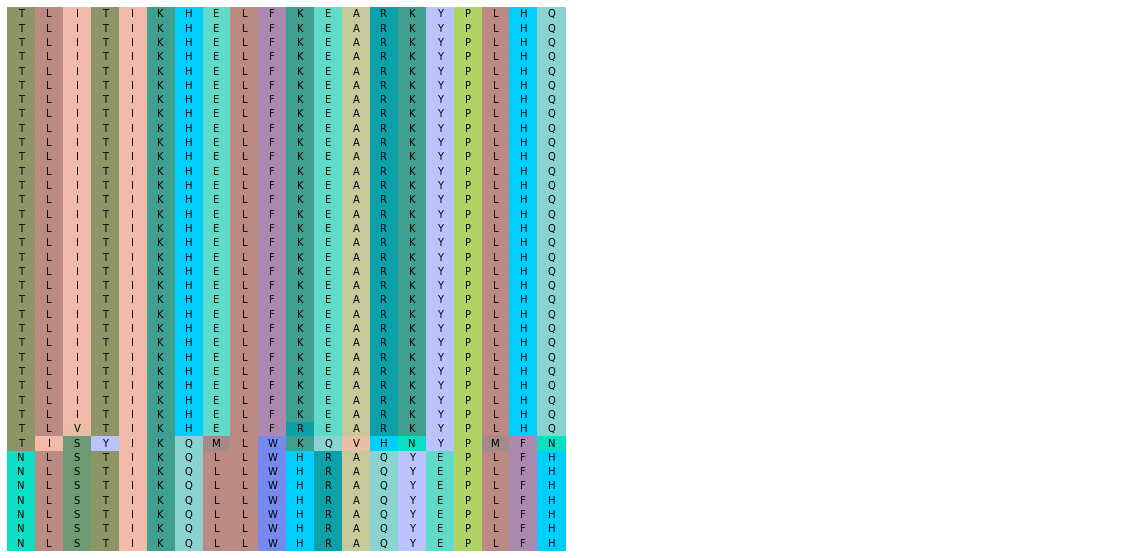

In [143]:

start_AA = 240

graphics.plot_alignment_type_based(
    plt.gca(), biotite_al[start_AA:start_AA+20], symbols_per_line=40,
    color_scheme="ocean")

## Step 4 - Extract residue subsets where there are no gaps

- only allow these residues to later be selected in the featurization

In [80]:
aligned_file = out_file
fasta_sequences = SeqIO.parse(open(aligned_file),'fasta')

In [81]:
# list of non-empty msa positions
msa_nonEmpty_flags = None
# dictionary id - non-empy indexes
nonempty_idx_maps = {}


#bookkeeping - see what amino-acids are common to everyone and can be selected in analysis
for f_seq in fasta_sequences:
    seq = str(f_seq.seq)
    # initialize the flags
    if msa_nonEmpty_flags is None:
        msa_nonEmpty_flags = [True for i in seq]
    # init the position map
    nonempty_idx_map = []
    # iterate through sequence
    # update msa nonempty map and nonempty index map
    cnt = 0
    for i, aa in enumerate(seq):
        if "-" in aa:
            msa_nonEmpty_flags[i] = False
            nonempty_idx_map.append(-1)
        else:
            nonempty_idx_map.append(cnt)
            cnt+=1
    nonempty_idx_maps[f_seq.id[-4:]] = nonempty_idx_map

msa_nonEmpty_pos = [i for i, flag in enumerate(msa_nonEmpty_flags) if flag == True]

In [88]:
# important - only these residues (global index) can be selected
print("Extracted: {}/{} AAs.".format(len(msa_nonEmpty_pos),len(seq))) 
# important - will have to map these residues into a local residue index

Extracted: 633/1260 AAs.


In [140]:
# Show continuous regions
cont_regs = []
cont_reg = []
cont_reg_inds = []
cont_regs_inds = []

for i, elem in enumerate(msa_nonEmpty_pos):
    if i == len(msa_nonEmpty_pos)-1:
        cont_reg.append(elem)
        cont_regs.append(cont_reg)
        break
    if msa_nonEmpty_pos[i+1]==msa_nonEmpty_pos[i]+1:
        cont_reg.append(elem)
    else: 
        if len(cont_reg)>0:
            cont_reg.append(elem)
            cont_regs.append(cont_reg)
            cont_reg = []
            print("Continuous region #{} found starting in AA range {}-{}".format(len(cont_regs), cont_regs[-1][0],
                                                                                 cont_regs[-1][-1]))


Continuous region #1 found starting in AA range 216-310
Continuous region #2 found starting in AA range 312-373
Continuous region #3 found starting in AA range 390-391
Continuous region #4 found starting in AA range 396-397
Continuous region #5 found starting in AA range 399-421
Continuous region #6 found starting in AA range 450-492
Continuous region #7 found starting in AA range 516-536
Continuous region #8 found starting in AA range 542-566
Continuous region #9 found starting in AA range 568-571
Continuous region #10 found starting in AA range 574-601
Continuous region #11 found starting in AA range 614-639
Continuous region #12 found starting in AA range 641-667
Continuous region #13 found starting in AA range 669-673
Continuous region #14 found starting in AA range 675-690
Continuous region #15 found starting in AA range 723-730
Continuous region #16 found starting in AA range 737-754
Continuous region #17 found starting in AA range 756-817


Continuous region #0 starting in AA range 216-310: of length 94


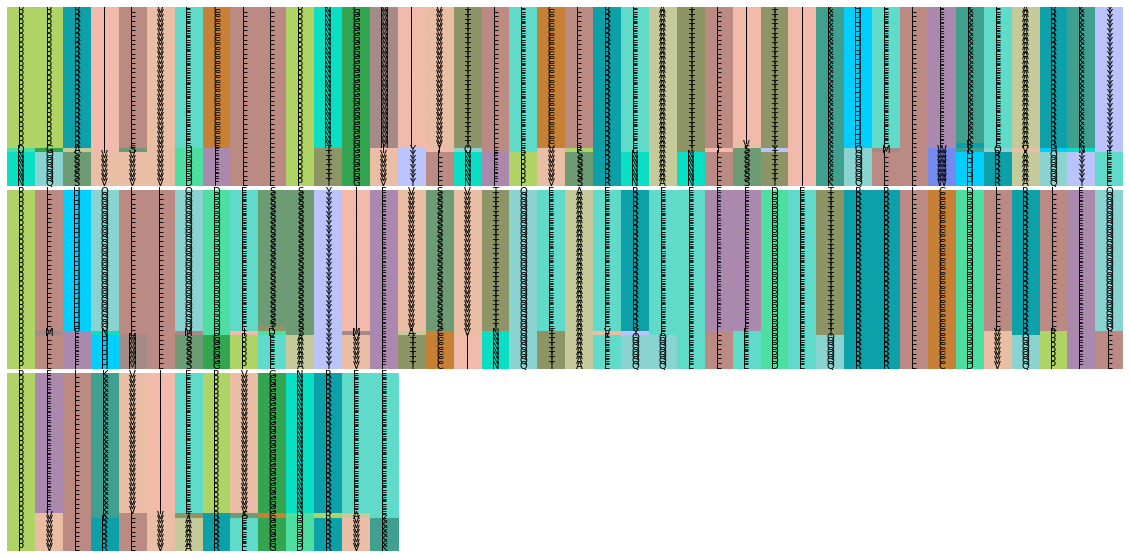

Continuous region #1 starting in AA range 312-373: of length 61


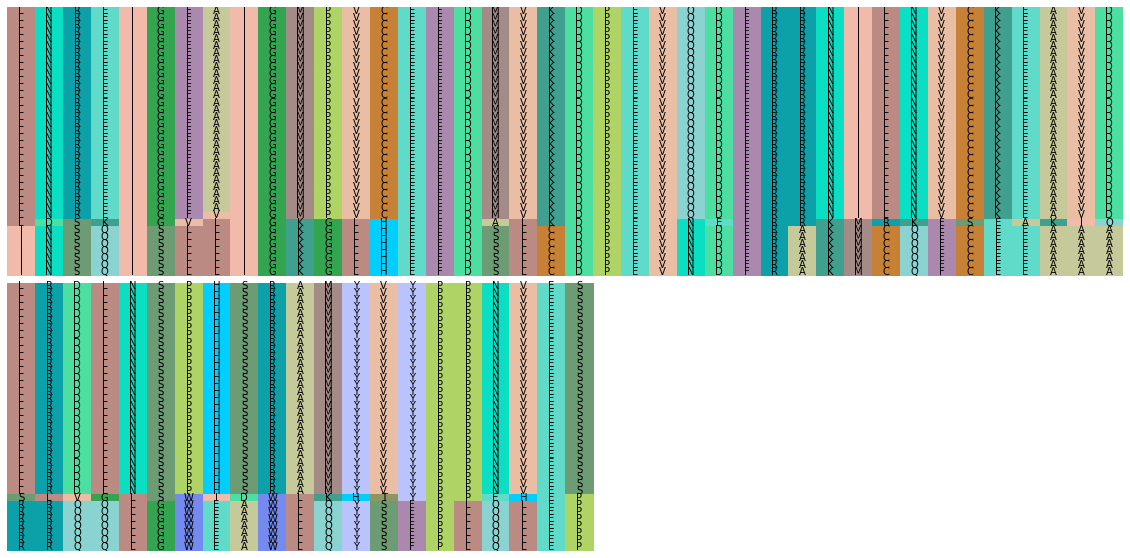

Continuous region #2 starting in AA range 390-421: of length 31


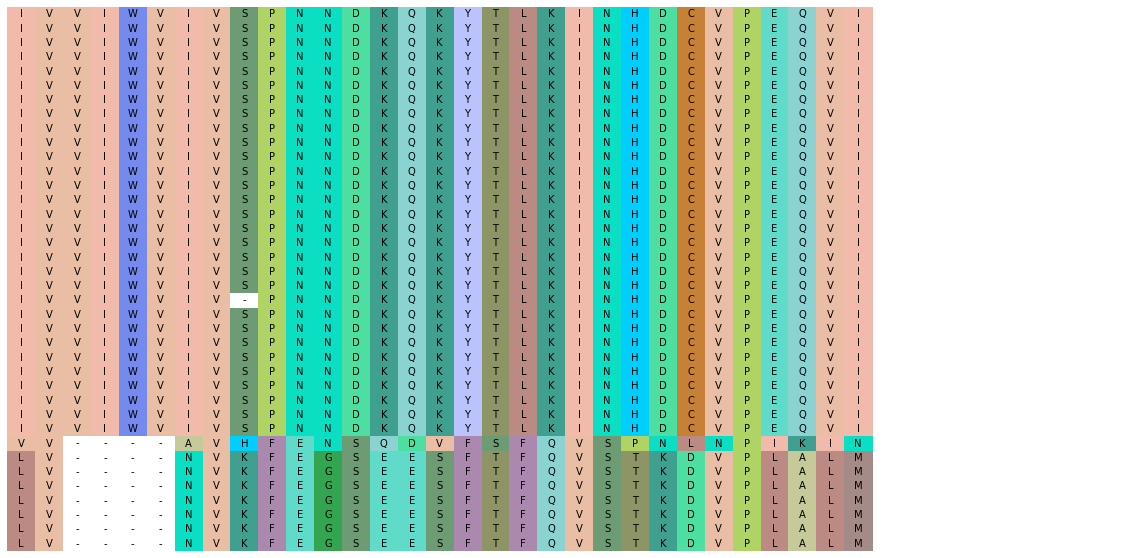

Continuous region #3 starting in AA range 450-492: of length 42


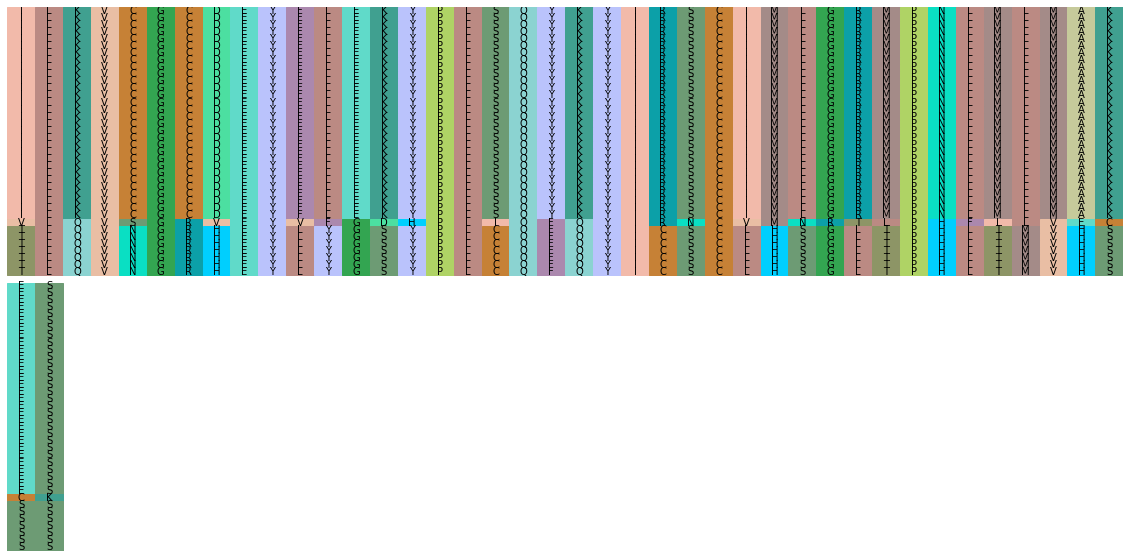

Continuous region #4 starting in AA range 516-536: of length 20


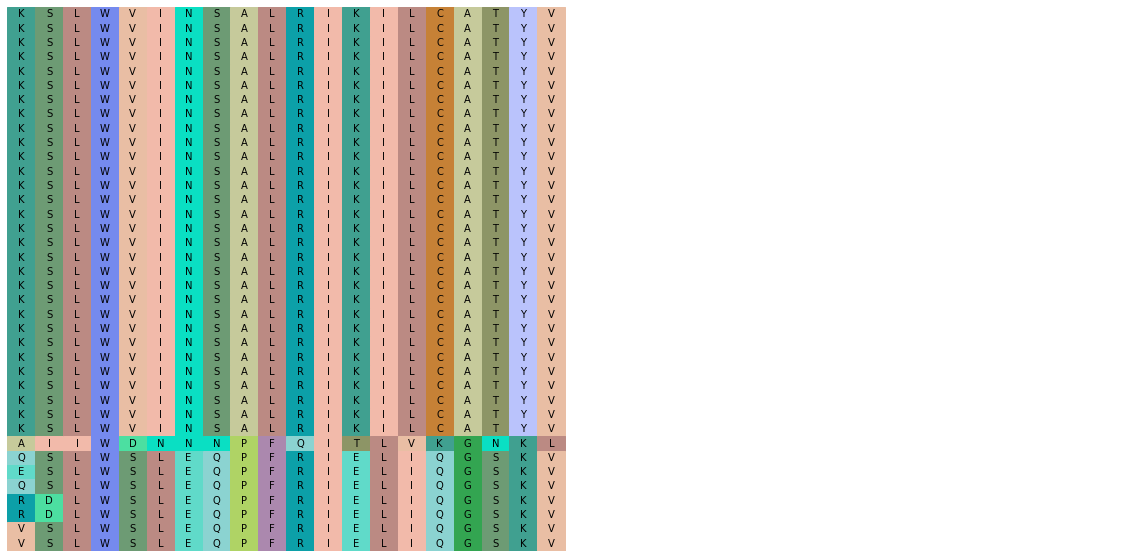

Continuous region #5 starting in AA range 542-566: of length 24


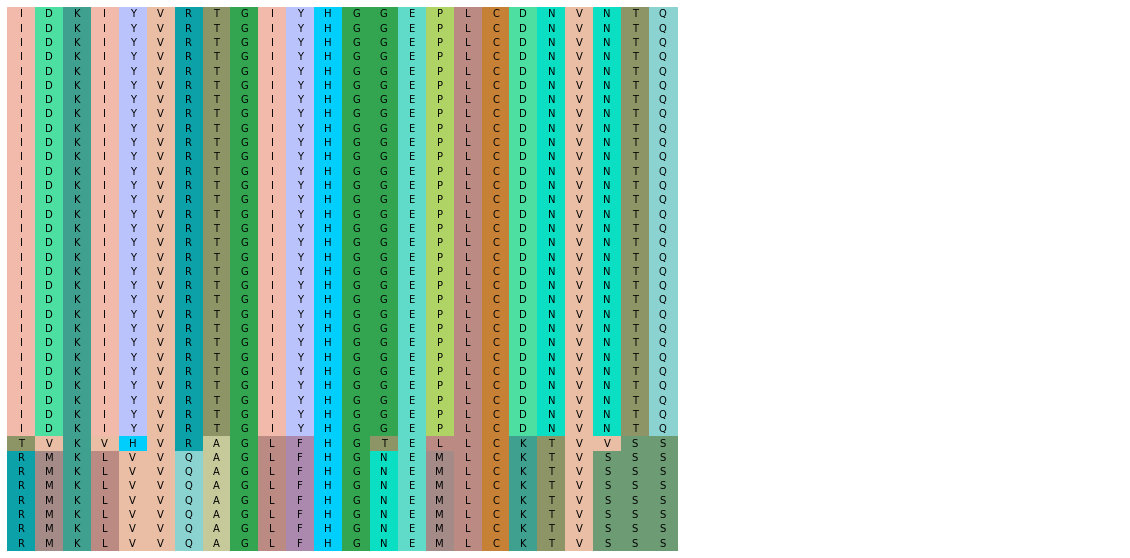

Continuous region #6 starting in AA range 568-571: of length 3


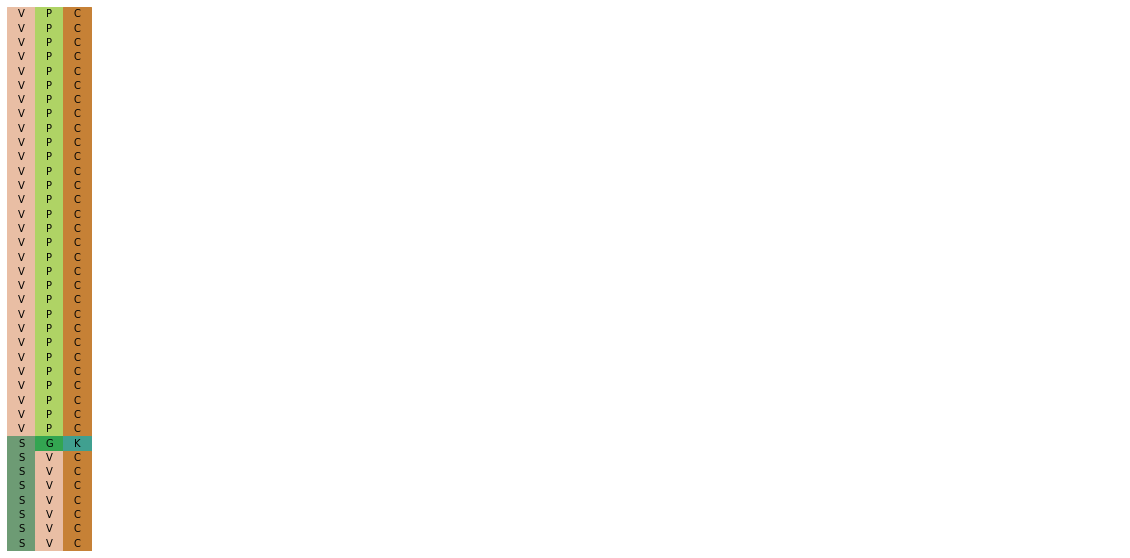

Continuous region #7 starting in AA range 574-601: of length 27


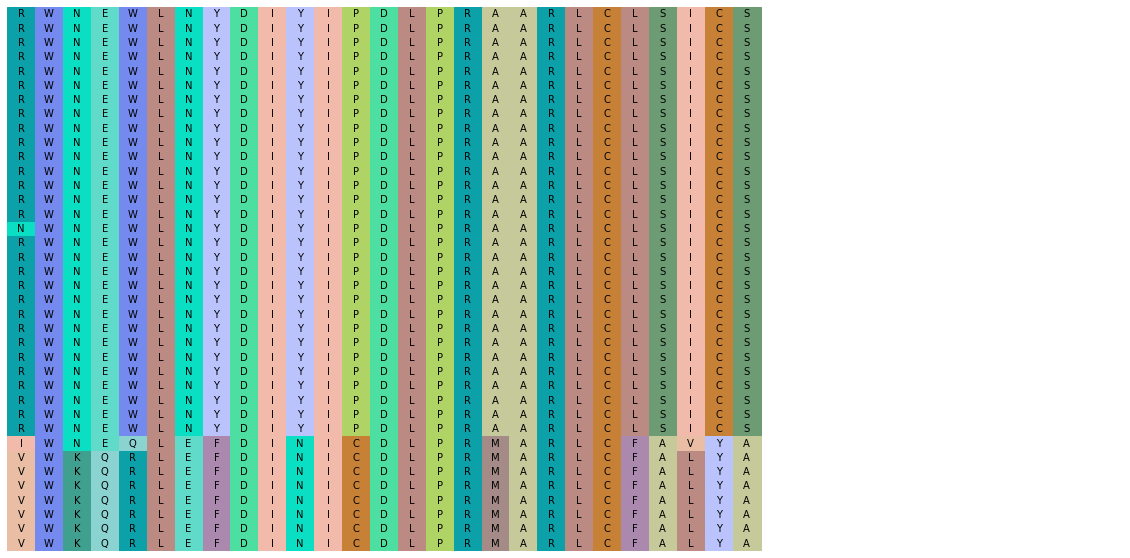

Continuous region #8 starting in AA range 614-639: of length 25


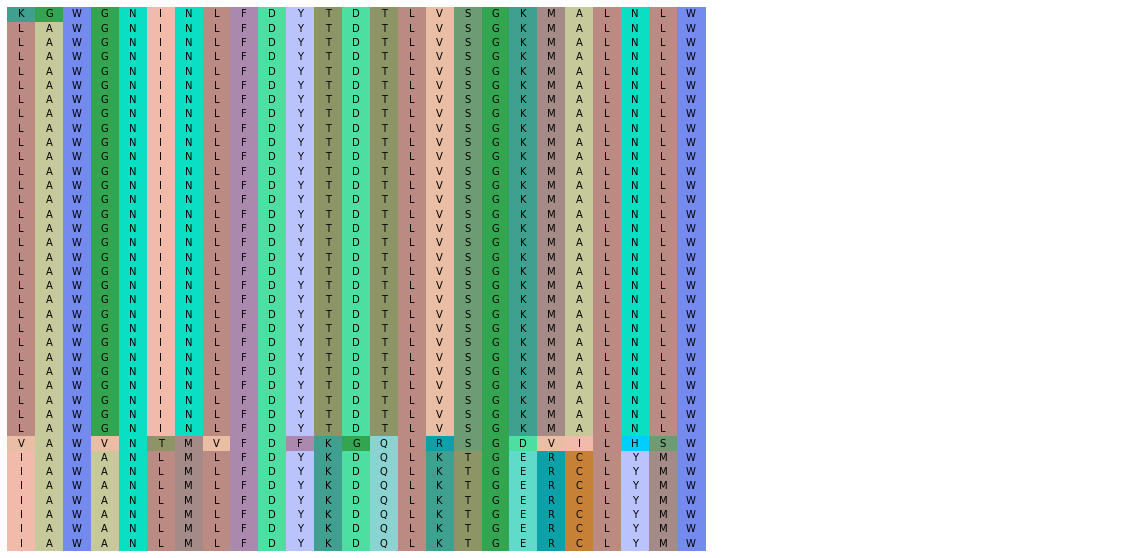

Continuous region #9 starting in AA range 641-667: of length 26


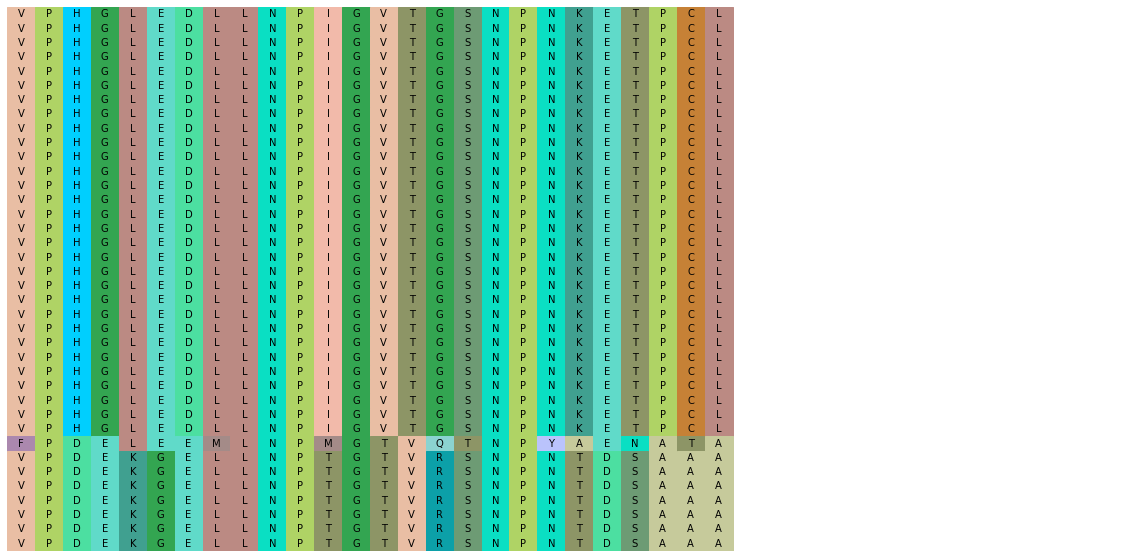

Continuous region #10 starting in AA range 669-673: of length 4


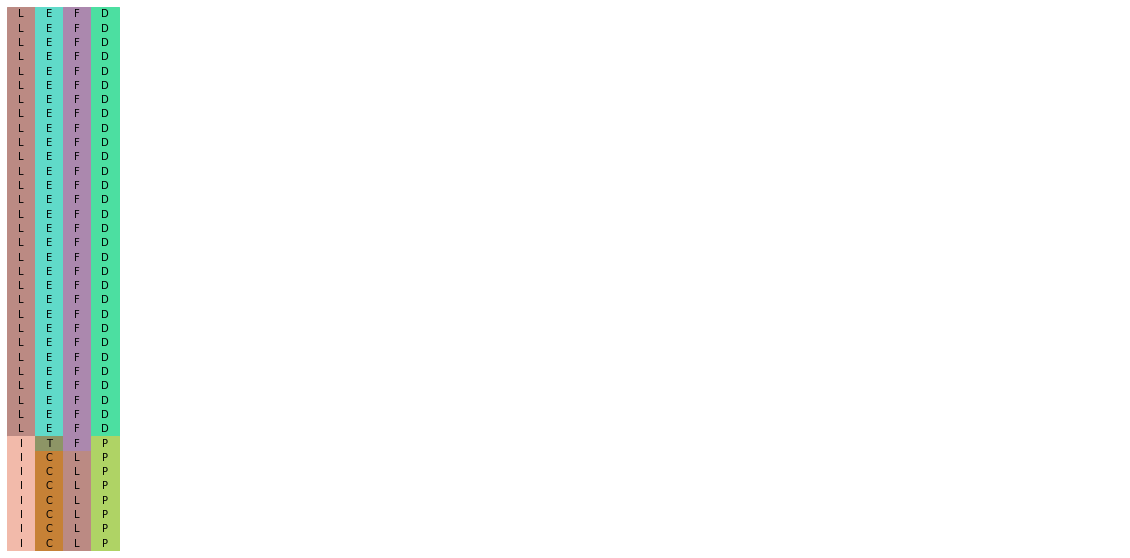

Continuous region #11 starting in AA range 675-690: of length 15


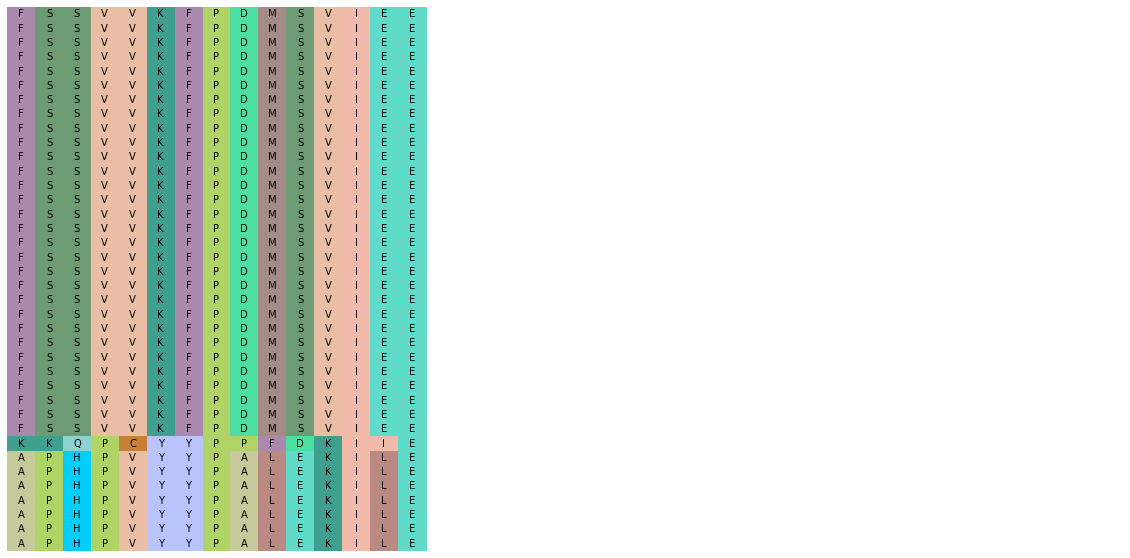

Continuous region #12 starting in AA range 723-730: of length 7


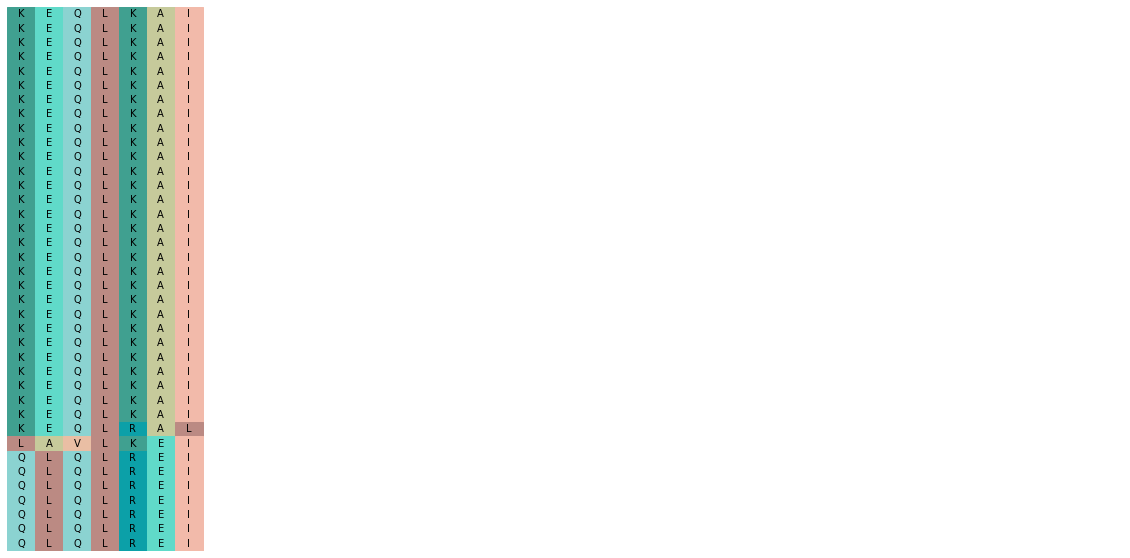

Continuous region #13 starting in AA range 737-754: of length 17


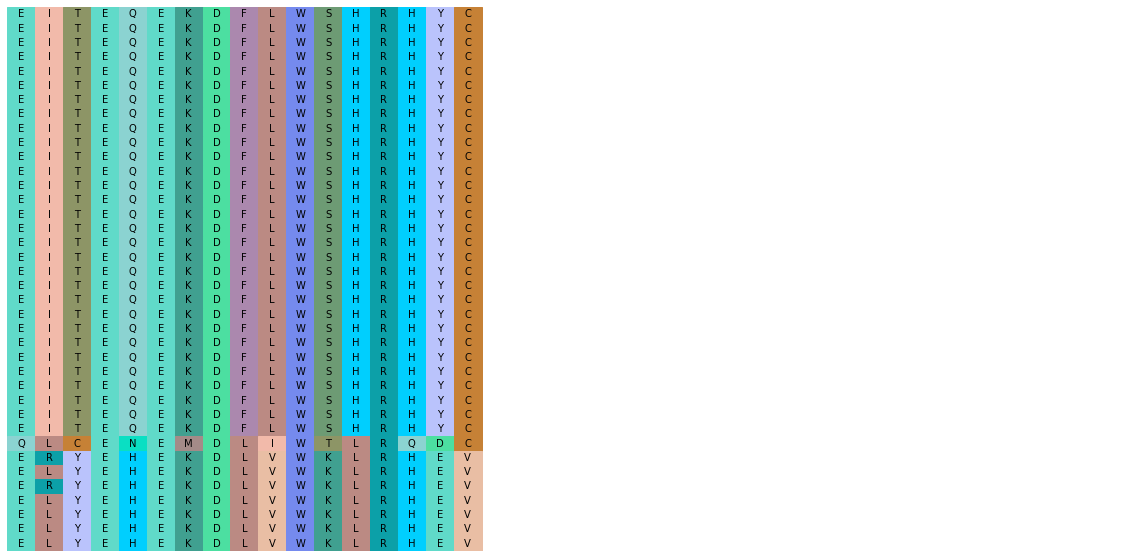

Continuous region #14 starting in AA range 756-817: of length 61


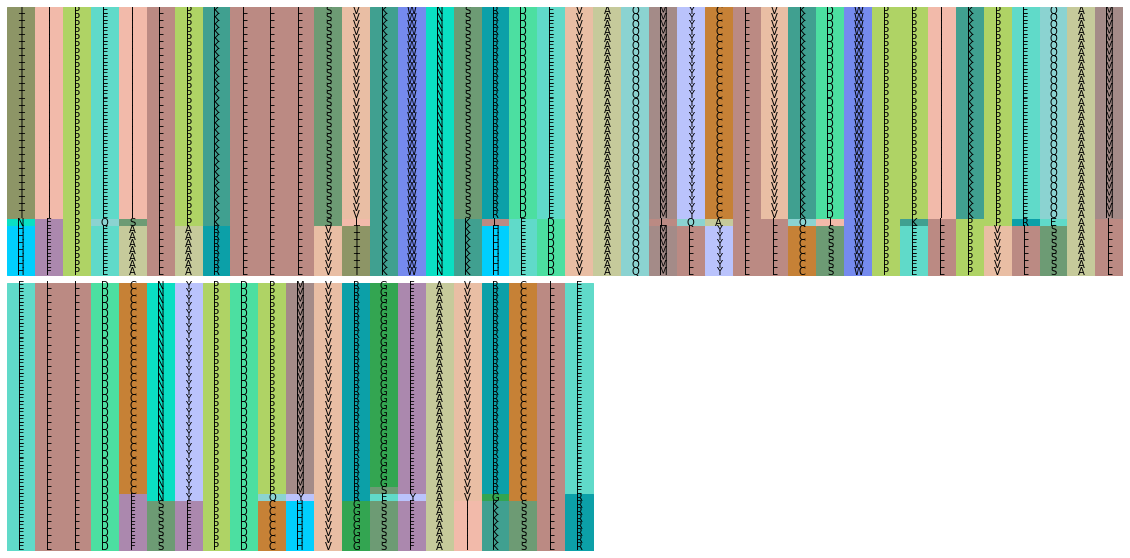

Continuous region #15 starting in AA range 819-983: of length 164


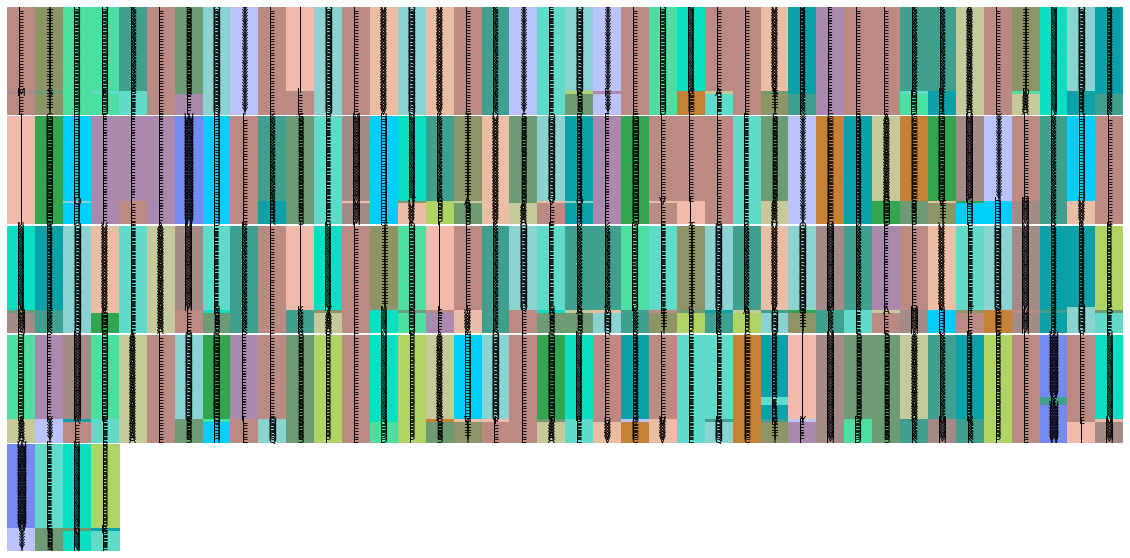

In [118]:
# Plot continuous regions alignments
for i, cr in enumerate(cont_regs):
    
    print("Continuous region #{} starting in AA range {}-{}: of length {}".format(i, 
                                                                          cont_regs[i][0], 
                                                                          cont_regs[i][-1],
                                                                                  cont_regs[i][-1]-cont_regs[i][0]
                                                                                 ))
    graphics.plot_alignment_type_based( plt.gca(), biotite_al[cont_regs[i][0]:cont_regs[i][-1]], symbols_per_line=40,
    color_scheme="ocean")
    plt.show()
    

In [119]:
# Save all this info in the structure with:
# pdb_id
# file location
# list of allowed to select residues (0-indexed per file) (based on MSA)
pdb_elements = []
for i, pdb_id in enumerate(pdbIds):
    if not pdb_id in nonempty_idx_maps: continue
    pdb_struct = {}
    pdb_struct["pdb_id"] = pdb_id
    pdb_struct["file_loc"] = pdb_files[i]
    pdb_struct["residue_idx_map"] = nonempty_idx_maps[pdb_id]
    pdb_elements.append(pdb_struct)


## Step 5 - save backbone of the common residues into a trajectory

Only for visualization purposes - the featurization will be done on side chains too.

Might take a while!

In [122]:
single_frames = []
for pdb_elem in pdb_elements:
    print(pdb_elem["pdb_id"])
    # read file, take subset of residues, save backbone 
    tmp_top = mdtraj.load(pdb_elem["file_loc"]).top
    allowed_residues = [pdb_elem["residue_idx_map"][x] for x in msa_nonEmpty_pos] 
    selstr = " or ".join(["resid == "+str(t) for  t in allowed_residues])
    selstr = " backbone and ({})".format(selstr)
    atom_sel = tmp_top.select(selstr)
    single_frames.append(mdtraj.load(pdb_elem["file_loc"], atom_indices= atom_sel))

2rd0
3hhm
3hiz
4jps
4l1b
4l23
4l2y
4ovu
4ovv
4waf
4ykn
4zop
5dxh
5fi4
5itd
5sw8
5swg
5swo
5sx8
5sx9
5sxf
5sxk
5uk8
5ukj
5ul1
5xgh
5xgi
5xgj
6nct
4a55
2y3a
5dxu
5m6u
5t8f
5ubt
5vlr
6g6w
6pyr
6pyu


In [123]:
# check if all elems have the same number of atoms - if not remove the element
n_atoms = single_frames[0].n_atoms
for i, pdb_elem in enumerate(pdb_elements):
    if not single_frames[i].n_atoms == n_atoms:
        print(i)
        print("Removing")
        print(pdb_elem["pdb_id"])
        del single_frames[i]
        del pdb_elements[i]

10
Removing
4ykn


In [126]:
cmd = ["mdconvert", "-f", os.path.join(pdir, "*_bbstrip.pdb"), "-o", "tmp_traj.xtc"]

In [128]:
subprocess.run(cmd)

CompletedProcess(args=['mdconvert', '-f', './PI3Ks_pdbs/*_bbstrip.pdb', '-o', 'tmp_PI3K_traj.xtc'], returncode=0)

## Step 6 - save common residue pdb files (for work with EnGens)

Might take a while!

In [129]:
for pdb_elem in pdb_elements:
    print(pdb_elem["pdb_id"])
    # read file, take subset of residues, save backbone 
    tmp_top = mdtraj.load(pdb_elem["file_loc"]).top
    allowed_residues = [pdb_elem["residue_idx_map"][x] for x in msa_nonEmpty_pos] 
    selstr = " or ".join(["resid == "+str(t) for  t in allowed_residues])
    selstr = " ({})".format(selstr)
    print("select atoms")
    atom_sel = tmp_top.select(selstr)
    print("save files")
    mdtraj.load(pdb_elem["file_loc"], atom_indices= atom_sel).save(pdb_elem["file_loc"][:-4]+"resstip.pdb")

2rd0
select atoms
save files
3hhm
select atoms
save files
3hiz
select atoms
save files
4jps
select atoms
save files
4l1b
select atoms
save files
4l23
select atoms
save files
4l2y
select atoms
save files
4ovu
select atoms
save files
4ovv
select atoms
save files
4waf
select atoms
save files
4zop
select atoms
save files
5dxh
select atoms
save files
5fi4
select atoms
save files
5itd
select atoms
save files
5sw8
select atoms
save files
5swg
select atoms
save files
5swo
select atoms
save files
5sx8
select atoms
save files
5sx9
select atoms
save files
5sxf
select atoms
save files
5sxk
select atoms
save files
5uk8
select atoms
save files
5ukj
select atoms
save files
5ul1
select atoms
save files
5xgh
select atoms
save files
5xgi
select atoms
save files
5xgj
select atoms
save files
6nct
select atoms
save files
4a55
select atoms
save files
2y3a
select atoms
save files
5dxu
select atoms
save files
5m6u
select atoms
save files
5t8f
select atoms
save files
5ubt
select atoms
save files
5vlr
select at

# Output of the file preparation process: crystal structure backbone "trajectory" and prepared structures

# Now - continue with the normal workflow: but add the list of pdb files as an argument to EnGens

- remember to align the trajectory (align = True when constructing EnGen)
- make sure your binding_site_selstr is something that is generalizable to different possibly mutated residues
- same for the featurization (do not use all atom featurization - since different residues have different number of atoms)
- do not use TICA/HDE
- do not use VAMP nets to select features

these are only for use with time series data (MDs)

In [8]:
import glob
# input files:
pdb_files_processed = glob.glob("./PI3Ks_pdbs/*resstip.pdb")

# Workflow 1 - extract features from the PDB files

**Input:** reference PDB and trajectory


**Output:** featurized trajectory
<hr>
Steps:

1. Load reference PDB and trajectory in the EnGen object
3. Provide set of featurizations of interest (or use default)
4. Evaluate different featurization (optional)
5. Choose the best featurization
6. Extract those features

In [9]:
# required imports 
from engens.core.EnGens import *
import engens.core.FeatureSelector as fs
import pickle
import mdshare
import mdtraj
import numpy as np
import nglview
from IPython.display import Javascript, display
import json

### Step 1 - load the structure and trajectory

Provide the path to the files with the reference trajectory and topology.
(You can use any format that <a fref = https://mdtraj.org/1.9.4/api/generated/mdtraj.load.html> mdtraj.load </a> will take as input).

Optionally, provide a subset of the structure that you will use for featurization (e.g. binding site) as a <a href=https://mdtraj.org/1.9.4/atom_selection.html> atom selection string </a> or a list of atom indices.


In [11]:
# Location of trajectory and topology files
# (you can specify your own files here)

# any random bbstrip file
top_loc = pdir+pdbIds[0]+'_bbstrip.pdb'
# backbone - common residue trajectory
traj_loc = 'tmp_traj.xtc'
# input files - containing full common residues
input_files = pdb_files_processed

engen = EnGen(traj_loc, top_loc, cryst_pdb_list = True, file_names = input_files, align=True)


Loading files (might take a while): 100%|██████████| 38/38 [00:26<00:00,  1.46it/s]


In [ ]:
nglwidget = select_residues_nglview(top_loc)
nglwidget

In [152]:
## Option 4 - continue selection 1
selection = None
display(Javascript(js_script))

<IPython.core.display.Javascript object>

In [154]:
## Option 4 - continue selection 2
if not selection is None and len(selection) > 0:
    binding_site_selstr = get_selstring(selection)
    #binding_site_selstr = "(10 <= resid) and (resid <= 50)" 
    engen = EnGen(traj_loc, top_loc, binding_site_selstr, align = True)

#------------------------end of options----------------------------#

In [12]:

#visualize the trajectory (optional - if trajectory too large, skip this step)
nglwidget = engen.show_animated_traj()
nglwidget.clear_representations()
nglwidget.add_ball_and_stick()
nglwidget.center()
nglwidget

NGLWidget(max_frame=37)

### Step 2 - select different featurizations

Here we select ways to featurize the trajectory. Any PyEmma <a href = http://www.emma-project.org/latest/api/generated/pyemma.coordinates.featurizer.html> trajectory featurization </a> can be used in this step and any of the parameters of the respective featurizations can be provided. Users can also use the default initialization which includes three sets of features: (1) amino-acid pairwise distances; (2) torsion angles and (3) amino-acid pairwise distances with the torsion angels.

In [13]:
# remove any existing featurizers
engen.reset_featurizers()
# initialize default features 
engen.init_featurizers_default()
description = engen.describe_featurizers()
print(description)

Adding featurizers per PDB file..: 100%|██████████| 38/38 [00:27<00:00,  1.36it/s]

Featurizer no. (residues may differ from file to file) 0:
 residue_COM
['PRO17 COM-x (all)', 'PRO17 COM-y (all)', 'PRO17 COM-z (all)', 'PRO18 COM-x (all)', 'PRO18 COM-y (all)', 'PRO18 COM-z (all)', 'ARG19 COM-x (all)', 'ARG19 COM-y (all)', 'ARG19 COM-z (all)', 'ILE20 COM-x (all)']...['GLU784 COM-z (all)', 'ASN785 COM-x (all)', 'ASN785 COM-y (all)', 'ASN785 COM-z (all)', 'PRO786 COM-x (all)', 'PRO786 COM-y (all)', 'PRO786 COM-z (all)', 'ASP787 COM-x (all)', 'ASP787 COM-y (all)', 'ASP787 COM-z (all)']
 


### Step 3 - evaluate the featurizations

This step is optional - we recommend evaluating the featurizations and picking the best using PyEmma's implementation of <a href=http://www.emma-project.org/latest/tutorials/notebooks/00-pentapeptide-showcase.html#Feature-selection> VAMP approach </a>.

This helps you choose a set of features with which to proceed to the next Workflow.

### Not an option for crystal structure input!!

### Step 4 - pick the featurization

We suggest using the featurization which gives you the highest VAMP2 score from the analysis above. To do so, run the cell below.

In [14]:
#apply features
engen.apply_featurizations()
#print possible features
print(engen.describe_featurizers())
#select the number of the desired feature
feat_num = 0
# initialize selector
featsel = fs.UserFeatureSelection(feat_num, engen)
#select the feature
featsel.select_feature()

Applying featurization per PDB file: 38it [00:07,  4.94it/s]

Featurizer no. (residues may differ from file to file) 0:
 residue_COM
['PRO17 COM-x (all)', 'PRO17 COM-y (all)', 'PRO17 COM-z (all)', 'PRO18 COM-x (all)', 'PRO18 COM-y (all)', 'PRO18 COM-z (all)', 'ARG19 COM-x (all)', 'ARG19 COM-y (all)', 'ARG19 COM-z (all)', 'ILE20 COM-x (all)']...['GLU784 COM-z (all)', 'ASN785 COM-x (all)', 'ASN785 COM-y (all)', 'ASN785 COM-z (all)', 'PRO786 COM-x (all)', 'PRO786 COM-y (all)', 'PRO786 COM-z (all)', 'ASP787 COM-x (all)', 'ASP787 COM-y (all)', 'ASP787 COM-z (all)']
 
Picked featurized no. 0: residue_COM
['PRO17 COM-x (all)', 'PRO17 COM-y (all)', 'PRO17 COM-z (all)', 'PRO18 COM-x (all)', 'PRO18 COM-y (all)', 'PRO18 COM-z (all)', 'ARG19 COM-x (all)', 'ARG19 COM-y (all)', 'ARG19 COM-z (all)', 'ILE20 COM-x (all)', 'ILE20 COM-y (all)', 'ILE20 COM-z (all)', 'LEU21 COM-x (all)', 'LEU21 COM-y (all)', 'LEU21 COM-z (all)', 'VAL22 COM-x (all)', 'VAL22 COM-y (all)', 'VAL22 COM-z (all)', 'GLU23 COM-x (all)', 'GLU23 COM-y (all)', 'GLU23 COM-z (all)', 'CYS24 COM-x (

### Step 5 - save the results as input for Workflow2 - dimensionality reduction

In [19]:
# save the results for next workflow
with open("wf1_resulting_EnGen.pickle", "wb") as file:
    pickle.dump(engen, file, -1)